# **SYMBOLIC MACHINE LEARNING**



---



***INSTALL GDAL :***

In [0]:
!pip install gdal
!pip install rasterio

***MOUNT DRIVE ON GOOGLE COLLABORATORY :***


In [0]:
from google.colab import drive
drive.mount('/content/drive')



---



***IMPORT PACKAGES :***

In [0]:
import gdal
from gdalconst import GA_ReadOnly 
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import numpy as np
from collections import Counter
from tqdm import tqdm_notebook as tqdm
IMG_SIZE=1113
import rasterio
from rasterio.plot import show



---



***GDAL : CROPPING MANNHEIM AREA-SENTINEL-2 IMAGE FROM CORINE LAND COVER(CLC)-EUROPE AREA***

In [0]:
data=gdal.Open('mannheim.tif',GA_ReadOnly) 
geoTransform=data.GetGeoTransform() 
minx=geoTransform[0] 
maxy=geoTransform[3] 
maxx = minx + geoTransform[1] * data.RasterXSize 
miny = maxy + geoTransform[5] * data.RasterYSize 
subprocess.call('gdal_translate -projwin ' + ' '.join([str(x) for x in [minx, maxy, maxx, miny]]) + ' -of GTiff clc.tif img_out.tif', shell=True) 
#subprocess.call('gdal_translate -of JPEG -co QUALITY=90 -co PROGRESSIVE=ON -outsize 1000 1000 -r bilinear clc.tif Y.jpg')
#subprocess.call('gdal_translate -of JPEG -co QUALITY=90 -co PROGRESSIVE=ON -outsize 1000 1000 -r bilinear mannheim.tif X.jpg')





---



**DISPLAY MANNHEIM IMAGE AND REFERENCE CORINE LAND COVER OF SAME REGION**

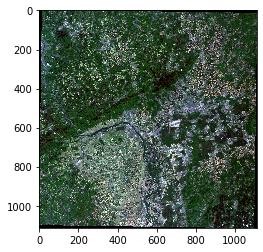

In [130]:
dataset = rasterio.open('/content/drive/My Drive/Colab_Notebooks/X-1.tif')
show(dataset.read([1,2,3]))

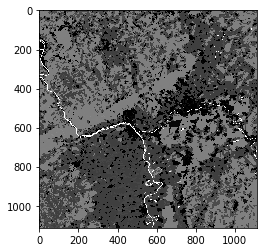

In [131]:
dataset = rasterio.open('/content/drive/My Drive/Colab_Notebooks/Y.tif')
show(dataset.read([1]))

 ***3 CLASSES :
 BLACK = BUILT UP AREA , 
 WHITE = RIVER/WATER BODIES , 
 OTHER COLORS = OTHER OBJECTS***


In [0]:
#IMPORT SENTNEL IMAGE OF MANNHEIM AREA - INPUT DATA
tif1=gdal.Open('/content/drive/My Drive/Colab_Notebooks/X-1.tif')
rband = tif1.GetRasterBand(1).ReadAsArray()
gband = tif1.GetRasterBand(2).ReadAsArray()
bband = tif1.GetRasterBand(3).ReadAsArray()


In [133]:
#IMPORT SENTNEL IMAGE OF MANNHEIM AREA-CORINE LAND COVER - REFERENCE DATA
tif2=gdal.Open('/content/drive/My Drive/Colab_Notebooks/Y.tif')
Y_raster = tif2.GetRasterBand(1).ReadAsArray()
Y_raster[Y_raster < 150] = 0
Y_raster[(Y_raster > 150) & (Y_raster < 500)] = 125
Y_raster[(Y_raster > 500) & (Y_raster < 530)] = 255
print("UNIQUE CLASSES: ", np.unique(Y_raster))
Y_list=Y_raster.flatten().tolist()

UNIQUE CLASSES:  [  0 125 255]




---



***STEP 1 : DATA QUANTIZATION-SEQUENCING***

In [0]:
#CONVERT RGB BANDS AS INPUT FEATURE SEQUENCES
#QUANTIZATION

rband_list=rband.flatten().tolist()
#rband_list = [round(x/8) for x in rband_list]

gband_list=gband.flatten().tolist()
#gband_list = [round(x/8) for x in gband_list]

bband_list=bband.flatten().tolist()
#bband_list = [round(x/8) for x in bband_list]


***SEQUENCE LIST AND ANTECEDENT-CONSEQUENT LIST(X->Y)***

In [0]:
sequences_list=[]
ante_consq_list=[]

In [136]:
for i in tqdm(range(IMG_SIZE*IMG_SIZE)):
  sequences_list.append((rband_list[i],gband_list[i],bband_list[i]))
  ante_consq_list.append((rband_list[i],gband_list[i],bband_list[i],Y_list[i]))

print('BUILDING DATA DONE')



BUILDING DATA DONE


***RANDOM EXAMPLE - DATA STRUCTURE (R, G, B, CLASS_LABEL)***

In [137]:
print ((ante_consq_list[22222]))

(20, 33, 12, 125)


***FIND UNIQUE SEQUENCES(X-cap) AND COUNT***

In [138]:
print('UNIQUE SEQUENCES COUNT: ')
print(len(list(set(sequences_list))))
unique_X_sequences=list(set(sequences_list))

UNIQUE SEQUENCES COUNT: 
364390




---



***STEP 2:***

*   ***ASSOCIATION ANALYSIS***
*   ***EVIDENCE BASED NORMALIZED DIFFERENTIAL INDEX(ENDI) MEASURE***




***HELPER FUNCTIONS:***

In [0]:
#ONE VARIATION OF ENDI INTERESTINGNESS MEASURE
def calculate_ENDI(positive,negative):
  if (positive==0) and (negative==0) : return 0
  return (positive-negative)/(positive+negative)

In [0]:
#POSITIVE EVIDENCES
def positive_count(sequence,class_name):
  item = list(sequence)
  item.append(class_name)
  c=counter[tuple(item)]
  return c


#NEGATIVE EVIDENCES
def negative_count(sequence, class_list):
  negative_classcount=0
  for c in  class_list:
    item = list(sequence)
    item.append(c)
    negative_classcount=negative_classcount+counter[tuple(item)]

  return negative_classcount



In [0]:
#COUNT OCCURANCE FREQUENCIES OF EACH UNIQUE SEQUENCE
counter=Counter(ante_consq_list)

***CALCULATE ENDI MEASURE FOR ALL THE CLASSES PER SEQUENCE DATA***

In [142]:
#GENERATE A DICTIONARY OF THE FORM : {(unique sequence) : [ENDI MEASURE-CLASS 0, ENDI MEASURE-CLASS 1, ENDI MEASURE-CLASS 2 ]}
ENDI_table_dictionary={}

for i in tqdm(range(len(unique_X_sequences))):
  seq=unique_X_sequences[i]
  ENDI_class_0=calculate_ENDI(positive_count(seq,0),negative_count(seq,[125,255]))
  ENDI_class_1=calculate_ENDI(positive_count(seq,125),negative_count(seq,[0,255]))
  ENDI_class_2=calculate_ENDI(positive_count(seq,255),negative_count(seq,[0,125]))
  ENDI_table_dictionary[seq]=[ENDI_class_0,ENDI_class_1,ENDI_class_2]

print('BUILDING DICTIONARY DONE')

#PRINT RANDOM DATA POINT
#print(ENDI_table_dictionary[unique_X_sequences[5000]])



BUILDING DICTIONARY DONE




---



***STEP 3 : CLASSIFICATION AND VISUALIZATION***

In [0]:
def classification(file_name):
          new_image=gdal.Open(file_name)
          rband_new = new_image.GetRasterBand(1).ReadAsArray()
          gband_new = new_image.GetRasterBand(2).ReadAsArray()
          bband_new = new_image.GetRasterBand(3).ReadAsArray()

          rband_list_new=rband_new.flatten().tolist()
          gband_list_new=gband_new.flatten().tolist()
          bband_list_new=bband_new.flatten().tolist()
          final_pred_list=[]

          for i in tqdm(range(len(rband_list))):

            if ((rband_list_new[i],gband_list_new[i],bband_list_new[i])) in ENDI_table_dictionary:
                  ENDI_vals=ENDI_table_dictionary[(rband_list_new[i],gband_list_new[i],bband_list_new[i])]
                  max_val = max(ENDI_vals)
                  index_max = ENDI_vals.index(max_val)
                  final_pred_list.append(index_max)   
            else:
              final_pred_list.append(2)
          return final_pred_list



In [0]:
def visualization(prediction_list):
  numpy_array=np.asarray(prediction_list)
  numpy_array[numpy_array == 1] = 125
  numpy_array[numpy_array == 2] = 255
  final_image_array=numpy_array.reshape((IMG_SIZE,IMG_SIZE))
  print(np.unique(final_image_array))
  plt.gray()
  plt.imshow(final_image_array)




---



**VISUALIZATION OF RESULTS - MANNHEIM AREA**

1) MANNHEIM CLASSIFICATION RESULTS


[  0 125 255]


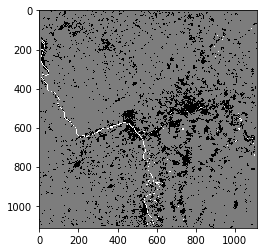

In [145]:
prediction_list=classification('/content/drive/My Drive/Colab_Notebooks/X-1.tif')
visualization(prediction_list)

2) MANNHEIM  RGB IMAGE

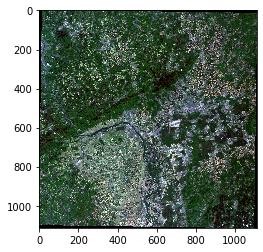

In [146]:
dataset = rasterio.open('/content/drive/My Drive/Colab_Notebooks/X-1.tif')
show(dataset.read([1,2,3]))

3) MANNHEIM REFERENCE DATA - CORINE LAND COVER

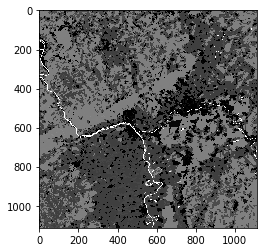

In [147]:
dataset = rasterio.open('/content/drive/My Drive/Colab_Notebooks/Y.tif')
show(dataset.read([1]))



---



**VISUALIZATION OF RESULTS - MUNCHEN AREA**

1) MUNCHEN CLASSIFICATION RESULTS


[  0 125 255]


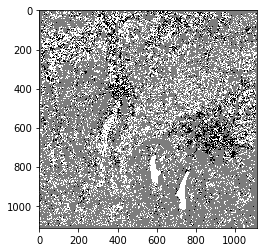

In [148]:
prediction_list=classification('/content/drive/My Drive/Colab_Notebooks/munchen.tif')
visualization(prediction_list)

2) MUNCHEN ORIGINAL RGB IMAGE

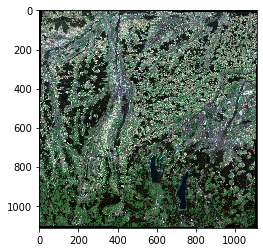

In [149]:
dataset = rasterio.open('/content/drive/My Drive/Colab_Notebooks/munchen.tif')
show(dataset.read([1,2,3]))

3) MUNCHEN REFERENCE DATA - CORINE LAND COVER

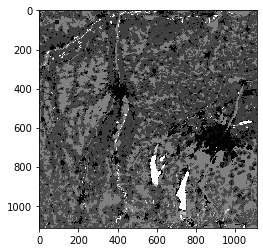

In [150]:
dataset = rasterio.open('/content/drive/My Drive/Colab_Notebooks/munchen-clc.tif')
show(dataset.read([1]))